# SETUP


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

PATH = "drive/MyDrive/!SSLPROJ"

Mounted at /content/drive


In [ ]:
!pip install h5py

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

# WORK

In [32]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
from data import get_dataset


transform_rgb = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize(mean=MEAN, std=STD)
])
transform_depth = Compose([
    Resize((256, 256)),
    ToTensor()
])
data_path = PATH + "/nyu_depth_v2_labeled.mat"
nyu_dataset = get_dataset(data_path, transform_rgb, transform_depth)

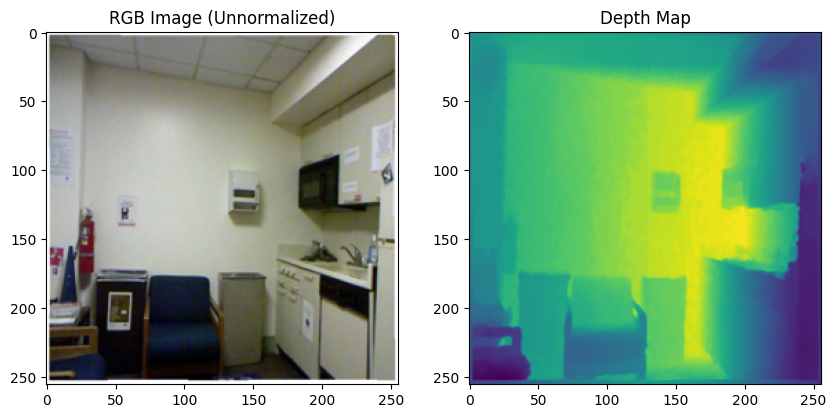

In [27]:
from utils import unnormalize


rgb, depth = nyu_dataset[0]

unnormalized_rgb = unnormalize(rgb, MEAN, STD).clamp(0, 1)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("RGB Image (Unnormalized)")
plt.imshow(unnormalized_rgb.permute(1, 2, 0).numpy())

plt.subplot(1, 2, 2)
plt.title("Depth Map")
plt.imshow(depth.squeeze().numpy(), cmap='viridis')

plt.show()


In [28]:
from utils import load_moco_v2_model


checkpoint_path = PATH + "/moco_v2_800ep_pretrain.pth.tar"
moco_v2_encoder = load_moco_v2_model(checkpoint_path)

print(moco_v2_encoder)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
from models import UNetWithResnetEncoder


moco_v2_encoder.eval()
unet_model = UNetWithResnetEncoder(moco_v2_encoder, out_channels=1)

In [31]:
from utils import get_loaders

train_loader, eval_loader = get_loaders(nyu_dataset)

In [51]:
from utils import train, plot_final_metrics


moco_v2_encoder = load_moco_v2_model(checkpoint_path)
moco_v2_encoder.eval()
unet_model = UNetWithResnetEncoder(moco_v2_encoder, out_channels=1)
unet_model = unet_model.to(device)

num_epochs = 50
learning_rate = 1e-4
optimizer = optim.Adam(unet_model.parameters(), lr=learning_rate)
criterion = nn.L1Loss()


metrics_moco = train(
    train_loader=train_loader,
    eval_loader=eval_loader,
    model=unet_model,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device
)

  2%|▏         | 1/50 [00:23<19:23, 23.75s/it]

Epoch [1/50] | Train Loss: 2.0976 | Val Loss: 1.8729 | RMSE: 2.3011


  4%|▍         | 2/50 [00:47<19:02, 23.80s/it]

Epoch [2/50] | Train Loss: 1.7923 | Val Loss: 1.6588 | RMSE: 2.1472


  6%|▌         | 3/50 [01:11<18:42, 23.88s/it]

Epoch [3/50] | Train Loss: 1.6383 | Val Loss: 1.5128 | RMSE: 2.0544


  8%|▊         | 4/50 [01:35<18:18, 23.89s/it]

Epoch [4/50] | Train Loss: 1.4880 | Val Loss: 1.3915 | RMSE: 1.9013


 10%|█         | 5/50 [01:59<17:57, 23.96s/it]

Epoch [5/50] | Train Loss: 1.3461 | Val Loss: 1.1657 | RMSE: 1.6747


 12%|█▏        | 6/50 [02:23<17:36, 24.00s/it]

Epoch [6/50] | Train Loss: 1.2137 | Val Loss: 0.9909 | RMSE: 1.4043


 14%|█▍        | 7/50 [02:47<17:10, 23.95s/it]

Epoch [7/50] | Train Loss: 1.0814 | Val Loss: 1.1389 | RMSE: 1.5779


 16%|█▌        | 8/50 [03:11<16:46, 23.97s/it]

Epoch [8/50] | Train Loss: 0.9460 | Val Loss: 0.8420 | RMSE: 1.2299


 18%|█▊        | 9/50 [03:35<16:22, 23.96s/it]

Epoch [9/50] | Train Loss: 0.8319 | Val Loss: 0.8397 | RMSE: 1.2156


 20%|██        | 10/50 [03:59<15:57, 23.93s/it]

Epoch [10/50] | Train Loss: 0.7281 | Val Loss: 0.6608 | RMSE: 0.9677


 22%|██▏       | 11/50 [04:23<15:34, 23.95s/it]

Epoch [11/50] | Train Loss: 0.6423 | Val Loss: 0.7323 | RMSE: 1.0536


 24%|██▍       | 12/50 [04:47<15:10, 23.97s/it]

Epoch [12/50] | Train Loss: 0.5734 | Val Loss: 0.5963 | RMSE: 0.8786


 26%|██▌       | 13/50 [05:11<14:44, 23.91s/it]

Epoch [13/50] | Train Loss: 0.4987 | Val Loss: 0.6380 | RMSE: 0.9575


 28%|██▊       | 14/50 [05:35<14:20, 23.91s/it]

Epoch [14/50] | Train Loss: 0.4614 | Val Loss: 0.5303 | RMSE: 0.7930


 30%|███       | 15/50 [05:58<13:55, 23.88s/it]

Epoch [15/50] | Train Loss: 0.4159 | Val Loss: 0.5146 | RMSE: 0.7627


 32%|███▏      | 16/50 [06:22<13:32, 23.91s/it]

Epoch [16/50] | Train Loss: 0.3934 | Val Loss: 0.5485 | RMSE: 0.7988


 34%|███▍      | 17/50 [06:46<13:09, 23.93s/it]

Epoch [17/50] | Train Loss: 0.3882 | Val Loss: 0.6424 | RMSE: 0.9670


 36%|███▌      | 18/50 [07:10<12:45, 23.91s/it]

Epoch [18/50] | Train Loss: 0.3966 | Val Loss: 0.5461 | RMSE: 0.7602


 38%|███▊      | 19/50 [07:34<12:21, 23.91s/it]

Epoch [19/50] | Train Loss: 0.3714 | Val Loss: 0.4749 | RMSE: 0.7036


 40%|████      | 20/50 [07:58<11:58, 23.94s/it]

Epoch [20/50] | Train Loss: 0.3413 | Val Loss: 0.5117 | RMSE: 0.7187


 42%|████▏     | 21/50 [08:22<11:33, 23.92s/it]

Epoch [21/50] | Train Loss: 0.3234 | Val Loss: 0.4975 | RMSE: 0.7368


 44%|████▍     | 22/50 [08:46<11:08, 23.88s/it]

Epoch [22/50] | Train Loss: 0.3202 | Val Loss: 0.4751 | RMSE: 0.6878


 46%|████▌     | 23/50 [09:10<10:45, 23.90s/it]

Epoch [23/50] | Train Loss: 0.3253 | Val Loss: 0.4921 | RMSE: 0.7023


 48%|████▊     | 24/50 [09:34<10:22, 23.93s/it]

Epoch [24/50] | Train Loss: 0.3080 | Val Loss: 0.4700 | RMSE: 0.6857


 50%|█████     | 25/50 [09:57<09:57, 23.88s/it]

Epoch [25/50] | Train Loss: 0.3033 | Val Loss: 0.4541 | RMSE: 0.6630


 52%|█████▏    | 26/50 [10:21<09:32, 23.86s/it]

Epoch [26/50] | Train Loss: 0.2932 | Val Loss: 0.5203 | RMSE: 0.7211


 54%|█████▍    | 27/50 [10:45<09:08, 23.84s/it]

Epoch [27/50] | Train Loss: 0.2943 | Val Loss: 0.4612 | RMSE: 0.6837


 56%|█████▌    | 28/50 [11:09<08:45, 23.86s/it]

Epoch [28/50] | Train Loss: 0.3074 | Val Loss: 0.4698 | RMSE: 0.7096


 58%|█████▊    | 29/50 [11:33<08:20, 23.85s/it]

Epoch [29/50] | Train Loss: 0.2791 | Val Loss: 0.4846 | RMSE: 0.7411


 60%|██████    | 30/50 [11:57<07:57, 23.88s/it]

Epoch [30/50] | Train Loss: 0.2850 | Val Loss: 0.4490 | RMSE: 0.6757


 62%|██████▏   | 31/50 [12:21<07:34, 23.90s/it]

Epoch [31/50] | Train Loss: 0.2760 | Val Loss: 0.4632 | RMSE: 0.6908


 64%|██████▍   | 32/50 [12:45<07:10, 23.91s/it]

Epoch [32/50] | Train Loss: 0.2620 | Val Loss: 0.4600 | RMSE: 0.6796


 66%|██████▌   | 33/50 [13:09<06:47, 23.96s/it]

Epoch [33/50] | Train Loss: 0.2509 | Val Loss: 0.4484 | RMSE: 0.6637


 68%|██████▊   | 34/50 [13:33<06:23, 23.98s/it]

Epoch [34/50] | Train Loss: 0.2662 | Val Loss: 0.4814 | RMSE: 0.7119


 70%|███████   | 35/50 [13:56<05:58, 23.91s/it]

Epoch [35/50] | Train Loss: 0.2576 | Val Loss: 0.4719 | RMSE: 0.6882


 72%|███████▏  | 36/50 [14:21<05:35, 23.96s/it]

Epoch [36/50] | Train Loss: 0.2465 | Val Loss: 0.4687 | RMSE: 0.6780


 74%|███████▍  | 37/50 [14:44<05:10, 23.92s/it]

Epoch [37/50] | Train Loss: 0.2616 | Val Loss: 0.4572 | RMSE: 0.6971


 76%|███████▌  | 38/50 [15:08<04:46, 23.85s/it]

Epoch [38/50] | Train Loss: 0.2714 | Val Loss: 0.4528 | RMSE: 0.6672


 78%|███████▊  | 39/50 [15:32<04:22, 23.86s/it]

Epoch [39/50] | Train Loss: 0.2542 | Val Loss: 0.4756 | RMSE: 0.6764


 80%|████████  | 40/50 [15:56<03:58, 23.86s/it]

Epoch [40/50] | Train Loss: 0.2658 | Val Loss: 0.4532 | RMSE: 0.6674


 82%|████████▏ | 41/50 [16:20<03:34, 23.83s/it]

Epoch [41/50] | Train Loss: 0.2558 | Val Loss: 0.4584 | RMSE: 0.6655


 84%|████████▍ | 42/50 [16:43<03:10, 23.85s/it]

Epoch [42/50] | Train Loss: 0.2444 | Val Loss: 0.4485 | RMSE: 0.6602


 86%|████████▌ | 43/50 [17:07<02:47, 23.88s/it]

Epoch [43/50] | Train Loss: 0.2482 | Val Loss: 0.4700 | RMSE: 0.7043


 88%|████████▊ | 44/50 [17:31<02:23, 23.87s/it]

Epoch [44/50] | Train Loss: 0.2256 | Val Loss: 0.4698 | RMSE: 0.7018


 90%|█████████ | 45/50 [17:55<01:59, 23.90s/it]

Epoch [45/50] | Train Loss: 0.2459 | Val Loss: 0.4605 | RMSE: 0.6647


 92%|█████████▏| 46/50 [18:19<01:35, 23.91s/it]

Epoch [46/50] | Train Loss: 0.2197 | Val Loss: 0.4474 | RMSE: 0.6615


 94%|█████████▍| 47/50 [18:43<01:11, 23.89s/it]

Epoch [47/50] | Train Loss: 0.2417 | Val Loss: 0.4613 | RMSE: 0.7302


 96%|█████████▌| 48/50 [19:07<00:47, 23.83s/it]

Epoch [48/50] | Train Loss: 0.2247 | Val Loss: 0.4448 | RMSE: 0.6528


 98%|█████████▊| 49/50 [19:30<00:23, 23.84s/it]

Epoch [49/50] | Train Loss: 0.2285 | Val Loss: 0.4643 | RMSE: 0.6904


100%|██████████| 50/50 [19:54<00:00, 23.90s/it]

Epoch [50/50] | Train Loss: 0.2317 | Val Loss: 0.4628 | RMSE: 0.6912


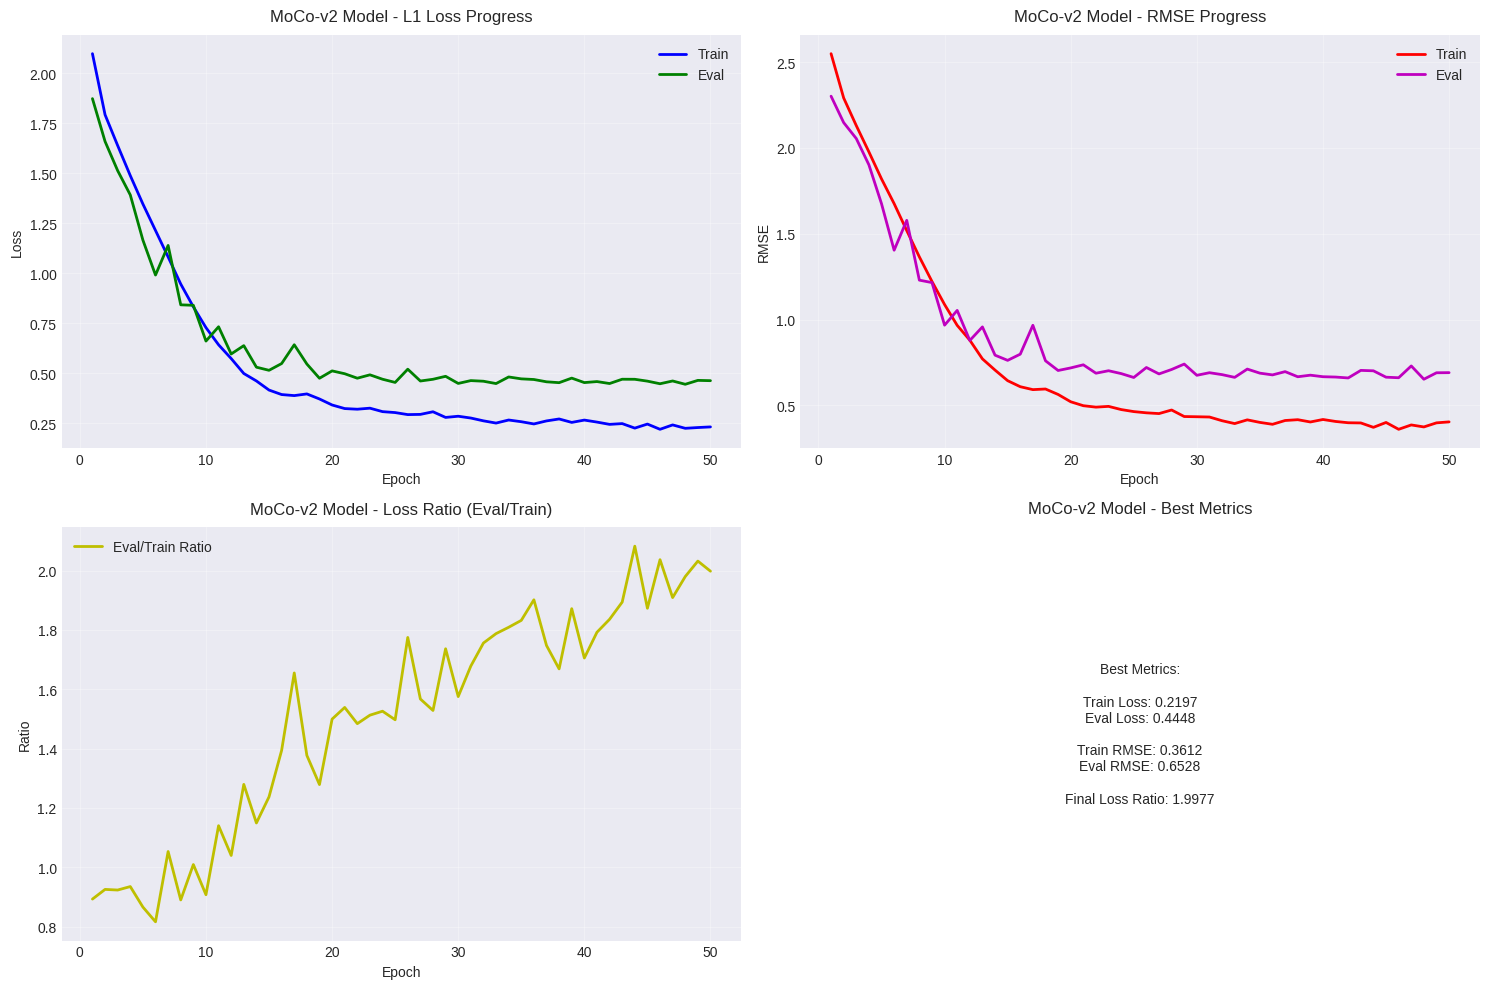

In [52]:
plot_final_metrics(metrics_moco)

In [67]:
from diffusers import UNet2DModel

hf_unet = UNet2DModel.from_pretrained("google/ddpm-cat-256")

In [84]:
from models import DiffusionUNet, DiffusionEncoder
from torch.utils.tensorboard import SummaryWriter
from utils import train_fp16
from torch.optim.lr_scheduler import CosineAnnealingLR


torch.cuda.empty_cache()
diffusion_backbone = DiffusionEncoder(hf_unet)
depth_model = DiffusionUNet(diffusion_backbone)
depth_model = depth_model.to(device)

num_epochs = 100
optimizer = torch.optim.Adam(depth_model.parameters(), lr=3e-4)
criterion = nn.L1Loss()
scaler = torch.amp.GradScaler('cuda')
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=num_epochs,
    eta_min=1e-6
)

writer = SummaryWriter(f'tensorboard/depth_estimation')

metrics_diff = train_fp16(
    train_loader=train_loader,
    eval_loader=eval_loader,
    model=depth_model,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    scaler=torch.amp.GradScaler('cuda'),
    writer=writer,
    scheduler=scheduler,
    save_path='checkpoints'
)

Channel sizes: {'down1': 128, 'down2': 256, 'down3': 512, 'mid': 512}


  1%|          | 1/100 [00:25<42:18, 25.64s/it]

Epoch [1/100] | Train Loss: 2.5886 | Val Loss: 2.2809 | RMSE: 2.8541


  2%|▏         | 2/100 [00:50<41:13, 25.24s/it]

Epoch [2/100] | Train Loss: 2.2443 | Val Loss: 2.1020 | RMSE: 2.5554


  3%|▎         | 3/100 [01:15<40:37, 25.13s/it]

Epoch [3/100] | Train Loss: 2.1012 | Val Loss: 2.0090 | RMSE: 2.4252


  4%|▍         | 4/100 [01:40<40:10, 25.11s/it]

Epoch [4/100] | Train Loss: 1.9289 | Val Loss: 1.9895 | RMSE: 3.1700


  5%|▌         | 5/100 [02:05<39:43, 25.09s/it]

Epoch [5/100] | Train Loss: 1.7753 | Val Loss: 1.6723 | RMSE: 2.3240


  6%|▌         | 6/100 [02:30<39:10, 25.01s/it]

Epoch [6/100] | Train Loss: 1.6297 | Val Loss: 1.5552 | RMSE: 2.1746


  7%|▋         | 7/100 [02:55<38:40, 24.95s/it]

Epoch [7/100] | Train Loss: 1.4920 | Val Loss: 1.4317 | RMSE: 1.9822


  8%|▊         | 8/100 [03:20<38:17, 24.97s/it]

Epoch [8/100] | Train Loss: 1.3624 | Val Loss: 1.3041 | RMSE: 1.7499


  9%|▉         | 9/100 [03:45<37:55, 25.00s/it]

Epoch [9/100] | Train Loss: 1.2292 | Val Loss: 1.1600 | RMSE: 1.6027


 10%|█         | 10/100 [04:10<37:28, 24.99s/it]

Epoch [10/100] | Train Loss: 1.1176 | Val Loss: 1.1284 | RMSE: 1.5562


 11%|█         | 11/100 [04:36<37:22, 25.19s/it]

Epoch [11/100] | Train Loss: 1.0206 | Val Loss: 0.9594 | RMSE: 1.3591


 12%|█▏        | 12/100 [05:01<36:56, 25.18s/it]

Epoch [12/100] | Train Loss: 0.9424 | Val Loss: 1.0458 | RMSE: 1.4513


 13%|█▎        | 13/100 [05:26<36:21, 25.07s/it]

Epoch [13/100] | Train Loss: 0.8835 | Val Loss: 0.9601 | RMSE: 1.3673


 14%|█▍        | 14/100 [05:51<35:52, 25.03s/it]

Epoch [14/100] | Train Loss: 0.8334 | Val Loss: 0.7800 | RMSE: 1.1066


 15%|█▌        | 15/100 [06:15<35:22, 24.97s/it]

Epoch [15/100] | Train Loss: 0.7939 | Val Loss: 0.7967 | RMSE: 1.1188


 16%|█▌        | 16/100 [06:40<34:53, 24.92s/it]

Epoch [16/100] | Train Loss: 0.7684 | Val Loss: 0.7746 | RMSE: 1.0896


 17%|█▋        | 17/100 [07:05<34:30, 24.95s/it]

Epoch [17/100] | Train Loss: 0.7390 | Val Loss: 0.8308 | RMSE: 1.1723


 18%|█▊        | 18/100 [07:30<34:03, 24.93s/it]

Epoch [18/100] | Train Loss: 0.7190 | Val Loss: 0.8010 | RMSE: 1.1381


 19%|█▉        | 19/100 [07:55<33:33, 24.86s/it]

Epoch [19/100] | Train Loss: 0.6973 | Val Loss: 0.7589 | RMSE: 1.0830


 20%|██        | 20/100 [08:20<33:16, 24.95s/it]

Epoch [20/100] | Train Loss: 0.6766 | Val Loss: 0.7518 | RMSE: 1.0423


 21%|██        | 21/100 [08:46<33:06, 25.15s/it]

Epoch [21/100] | Train Loss: 0.6621 | Val Loss: 0.7441 | RMSE: 1.0571


 22%|██▏       | 22/100 [09:11<32:40, 25.14s/it]

Epoch [22/100] | Train Loss: 0.6492 | Val Loss: 0.7279 | RMSE: 1.0234


 23%|██▎       | 23/100 [09:35<32:08, 25.04s/it]

Epoch [23/100] | Train Loss: 0.6256 | Val Loss: 0.7481 | RMSE: 1.0492


 24%|██▍       | 24/100 [10:00<31:36, 24.95s/it]

Epoch [24/100] | Train Loss: 0.6087 | Val Loss: 0.7270 | RMSE: 1.0263


 25%|██▌       | 25/100 [10:25<31:10, 24.94s/it]

Epoch [25/100] | Train Loss: 0.5838 | Val Loss: 0.7449 | RMSE: 1.0144


 26%|██▌       | 26/100 [10:50<30:46, 24.95s/it]

Epoch [26/100] | Train Loss: 0.5623 | Val Loss: 0.7147 | RMSE: 0.9961


 27%|██▋       | 27/100 [11:15<30:25, 25.01s/it]

Epoch [27/100] | Train Loss: 0.5493 | Val Loss: 0.7160 | RMSE: 1.0165


 28%|██▊       | 28/100 [11:40<30:00, 25.01s/it]

Epoch [28/100] | Train Loss: 0.5205 | Val Loss: 0.7268 | RMSE: 1.0174


 29%|██▉       | 29/100 [12:05<29:34, 25.00s/it]

Epoch [29/100] | Train Loss: 0.5087 | Val Loss: 0.7638 | RMSE: 1.1012


 30%|███       | 30/100 [12:30<29:08, 24.98s/it]

Epoch [30/100] | Train Loss: 0.5038 | Val Loss: 0.7813 | RMSE: 1.1155


 31%|███       | 31/100 [12:56<29:00, 25.22s/it]

Epoch [31/100] | Train Loss: 0.4901 | Val Loss: 0.7237 | RMSE: 1.0164


 32%|███▏      | 32/100 [13:21<28:30, 25.16s/it]

Epoch [32/100] | Train Loss: 0.4598 | Val Loss: 0.7121 | RMSE: 0.9924


 33%|███▎      | 33/100 [13:46<28:02, 25.11s/it]

Epoch [33/100] | Train Loss: 0.4525 | Val Loss: 0.7281 | RMSE: 1.0321


 34%|███▍      | 34/100 [14:11<27:29, 24.99s/it]

Epoch [34/100] | Train Loss: 0.4519 | Val Loss: 0.7121 | RMSE: 0.9892


 35%|███▌      | 35/100 [14:35<27:00, 24.94s/it]

Epoch [35/100] | Train Loss: 0.4435 | Val Loss: 0.7107 | RMSE: 0.9902


 36%|███▌      | 36/100 [15:00<26:37, 24.96s/it]

Epoch [36/100] | Train Loss: 0.4248 | Val Loss: 0.7136 | RMSE: 0.9879


 37%|███▋      | 37/100 [15:26<26:15, 25.00s/it]

Epoch [37/100] | Train Loss: 0.4076 | Val Loss: 0.6962 | RMSE: 0.9880


 38%|███▊      | 38/100 [15:50<25:48, 24.97s/it]

Epoch [38/100] | Train Loss: 0.4093 | Val Loss: 0.7173 | RMSE: 0.9906


 39%|███▉      | 39/100 [16:15<25:23, 24.97s/it]

Epoch [39/100] | Train Loss: 0.3911 | Val Loss: 0.6966 | RMSE: 0.9791


 40%|████      | 40/100 [16:40<24:54, 24.91s/it]

Epoch [40/100] | Train Loss: 0.3756 | Val Loss: 0.7238 | RMSE: 1.0255


 41%|████      | 41/100 [17:06<24:45, 25.18s/it]

Epoch [41/100] | Train Loss: 0.3790 | Val Loss: 0.6941 | RMSE: 0.9689


 42%|████▏     | 42/100 [17:31<24:18, 25.15s/it]

Epoch [42/100] | Train Loss: 0.3555 | Val Loss: 0.7132 | RMSE: 0.9834


 43%|████▎     | 43/100 [17:56<23:48, 25.06s/it]

Epoch [43/100] | Train Loss: 0.3659 | Val Loss: 0.7435 | RMSE: 1.0710


 44%|████▍     | 44/100 [18:21<23:20, 25.00s/it]

Epoch [44/100] | Train Loss: 0.3573 | Val Loss: 0.6926 | RMSE: 0.9680


 45%|████▌     | 45/100 [18:46<22:53, 24.98s/it]

Epoch [45/100] | Train Loss: 0.3365 | Val Loss: 0.7171 | RMSE: 0.9909


 46%|████▌     | 46/100 [19:11<22:26, 24.94s/it]

Epoch [46/100] | Train Loss: 0.3451 | Val Loss: 0.7072 | RMSE: 0.9794


 47%|████▋     | 47/100 [19:36<22:06, 25.03s/it]

Epoch [47/100] | Train Loss: 0.3295 | Val Loss: 0.6943 | RMSE: 0.9767


 48%|████▊     | 48/100 [20:01<21:43, 25.07s/it]

Epoch [48/100] | Train Loss: 0.3495 | Val Loss: 0.6948 | RMSE: 0.9772


 49%|████▉     | 49/100 [20:26<21:16, 25.03s/it]

Epoch [49/100] | Train Loss: 0.3207 | Val Loss: 0.6923 | RMSE: 0.9638


 50%|█████     | 50/100 [20:51<20:49, 24.99s/it]

Epoch [50/100] | Train Loss: 0.3086 | Val Loss: 0.6946 | RMSE: 0.9617


 51%|█████     | 51/100 [21:16<20:33, 25.17s/it]

Epoch [51/100] | Train Loss: 0.3140 | Val Loss: 0.6982 | RMSE: 0.9798


 52%|█████▏    | 52/100 [21:42<20:07, 25.17s/it]

Epoch [52/100] | Train Loss: 0.2990 | Val Loss: 0.6952 | RMSE: 0.9636


 53%|█████▎    | 53/100 [22:07<19:40, 25.11s/it]

Epoch [53/100] | Train Loss: 0.2925 | Val Loss: 0.6970 | RMSE: 0.9811


 54%|█████▍    | 54/100 [22:31<19:09, 25.00s/it]

Epoch [54/100] | Train Loss: 0.3031 | Val Loss: 0.6986 | RMSE: 0.9639


 55%|█████▌    | 55/100 [22:56<18:45, 25.00s/it]

Epoch [55/100] | Train Loss: 0.3047 | Val Loss: 0.6957 | RMSE: 0.9729


 56%|█████▌    | 56/100 [23:21<18:20, 25.01s/it]

Epoch [56/100] | Train Loss: 0.2807 | Val Loss: 0.6872 | RMSE: 0.9609


 57%|█████▋    | 57/100 [23:46<17:53, 24.97s/it]

Epoch [57/100] | Train Loss: 0.2911 | Val Loss: 0.6822 | RMSE: 0.9534


 58%|█████▊    | 58/100 [24:11<17:29, 24.99s/it]

Epoch [58/100] | Train Loss: 0.2940 | Val Loss: 0.6899 | RMSE: 0.9650


 59%|█████▉    | 59/100 [24:36<17:05, 25.02s/it]

Epoch [59/100] | Train Loss: 0.2834 | Val Loss: 0.6951 | RMSE: 0.9713


 60%|██████    | 60/100 [25:01<16:38, 24.96s/it]

Epoch [60/100] | Train Loss: 0.2776 | Val Loss: 0.6918 | RMSE: 0.9751


 61%|██████    | 61/100 [25:27<16:22, 25.19s/it]

Epoch [61/100] | Train Loss: 0.2918 | Val Loss: 0.6983 | RMSE: 0.9738


 62%|██████▏   | 62/100 [25:52<15:53, 25.10s/it]

Epoch [62/100] | Train Loss: 0.2857 | Val Loss: 0.6927 | RMSE: 0.9728


 63%|██████▎   | 63/100 [26:17<15:26, 25.04s/it]

Epoch [63/100] | Train Loss: 0.2596 | Val Loss: 0.6917 | RMSE: 0.9660


 64%|██████▍   | 64/100 [26:42<15:00, 25.02s/it]

Epoch [64/100] | Train Loss: 0.2469 | Val Loss: 0.6882 | RMSE: 0.9603


 65%|██████▌   | 65/100 [27:07<14:34, 24.98s/it]

Epoch [65/100] | Train Loss: 0.2559 | Val Loss: 0.6937 | RMSE: 0.9727


 66%|██████▌   | 66/100 [27:32<14:10, 25.03s/it]

Epoch [66/100] | Train Loss: 0.2553 | Val Loss: 0.6867 | RMSE: 0.9592


 67%|██████▋   | 67/100 [27:57<13:47, 25.07s/it]

Epoch [67/100] | Train Loss: 0.2427 | Val Loss: 0.6901 | RMSE: 0.9597


 68%|██████▊   | 68/100 [28:22<13:23, 25.10s/it]

Epoch [68/100] | Train Loss: 0.2400 | Val Loss: 0.6867 | RMSE: 0.9595


 69%|██████▉   | 69/100 [28:47<12:57, 25.09s/it]

Epoch [69/100] | Train Loss: 0.2376 | Val Loss: 0.6885 | RMSE: 0.9640


 70%|███████   | 70/100 [29:12<12:31, 25.05s/it]

Epoch [70/100] | Train Loss: 0.2280 | Val Loss: 0.6879 | RMSE: 0.9574


 71%|███████   | 71/100 [29:38<12:11, 25.24s/it]

Epoch [71/100] | Train Loss: 0.2361 | Val Loss: 0.6851 | RMSE: 0.9572


 72%|███████▏  | 72/100 [30:03<11:46, 25.23s/it]

Epoch [72/100] | Train Loss: 0.2222 | Val Loss: 0.6844 | RMSE: 0.9633


 73%|███████▎  | 73/100 [30:28<11:20, 25.19s/it]

Epoch [73/100] | Train Loss: 0.2208 | Val Loss: 0.6852 | RMSE: 0.9589


 74%|███████▍  | 74/100 [30:53<10:52, 25.11s/it]

Epoch [74/100] | Train Loss: 0.2228 | Val Loss: 0.6872 | RMSE: 0.9555


 75%|███████▌  | 75/100 [31:18<10:27, 25.09s/it]

Epoch [75/100] | Train Loss: 0.2127 | Val Loss: 0.6844 | RMSE: 0.9599


 76%|███████▌  | 76/100 [31:43<10:01, 25.08s/it]

Epoch [76/100] | Train Loss: 0.2066 | Val Loss: 0.6844 | RMSE: 0.9556


 77%|███████▋  | 77/100 [32:08<09:35, 25.03s/it]

Epoch [77/100] | Train Loss: 0.2143 | Val Loss: 0.6837 | RMSE: 0.9575


 78%|███████▊  | 78/100 [32:33<09:08, 24.95s/it]

Epoch [78/100] | Train Loss: 0.2050 | Val Loss: 0.6872 | RMSE: 0.9590


 79%|███████▉  | 79/100 [32:58<08:44, 24.99s/it]

Epoch [79/100] | Train Loss: 0.2040 | Val Loss: 0.6852 | RMSE: 0.9592


 80%|████████  | 80/100 [33:23<08:20, 25.01s/it]

Epoch [80/100] | Train Loss: 0.2009 | Val Loss: 0.6846 | RMSE: 0.9551


 81%|████████  | 81/100 [33:48<07:58, 25.18s/it]

Epoch [81/100] | Train Loss: 0.1984 | Val Loss: 0.6810 | RMSE: 0.9563


 82%|████████▏ | 82/100 [34:13<07:31, 25.10s/it]

Epoch [82/100] | Train Loss: 0.1978 | Val Loss: 0.6822 | RMSE: 0.9595


 83%|████████▎ | 83/100 [34:38<07:06, 25.07s/it]

Epoch [83/100] | Train Loss: 0.1891 | Val Loss: 0.6824 | RMSE: 0.9531


 84%|████████▍ | 84/100 [35:03<06:40, 25.05s/it]

Epoch [84/100] | Train Loss: 0.1843 | Val Loss: 0.6823 | RMSE: 0.9538


 85%|████████▌ | 85/100 [35:28<06:15, 25.03s/it]

Epoch [85/100] | Train Loss: 0.1954 | Val Loss: 0.6824 | RMSE: 0.9586


 86%|████████▌ | 86/100 [35:53<05:49, 25.00s/it]

Epoch [86/100] | Train Loss: 0.1891 | Val Loss: 0.6840 | RMSE: 0.9627


 87%|████████▋ | 87/100 [36:18<05:25, 25.06s/it]

Epoch [87/100] | Train Loss: 0.1887 | Val Loss: 0.6812 | RMSE: 0.9537


 88%|████████▊ | 88/100 [36:44<05:00, 25.08s/it]

Epoch [88/100] | Train Loss: 0.1846 | Val Loss: 0.6821 | RMSE: 0.9532


 89%|████████▉ | 89/100 [37:08<04:35, 25.03s/it]

Epoch [89/100] | Train Loss: 0.1791 | Val Loss: 0.6812 | RMSE: 0.9532


 90%|█████████ | 90/100 [37:34<04:10, 25.02s/it]

Epoch [90/100] | Train Loss: 0.1886 | Val Loss: 0.6821 | RMSE: 0.9573


 91%|█████████ | 91/100 [37:59<03:46, 25.21s/it]

Epoch [91/100] | Train Loss: 0.1856 | Val Loss: 0.6809 | RMSE: 0.9533


 92%|█████████▏| 92/100 [38:24<03:21, 25.13s/it]

Epoch [92/100] | Train Loss: 0.1840 | Val Loss: 0.6803 | RMSE: 0.9532


 93%|█████████▎| 93/100 [38:49<02:55, 25.03s/it]

Epoch [93/100] | Train Loss: 0.1775 | Val Loss: 0.6820 | RMSE: 0.9522


 94%|█████████▍| 94/100 [39:14<02:29, 25.00s/it]

Epoch [94/100] | Train Loss: 0.1812 | Val Loss: 0.6807 | RMSE: 0.9531


 95%|█████████▌| 95/100 [39:39<02:04, 24.95s/it]

Epoch [95/100] | Train Loss: 0.1836 | Val Loss: 0.6814 | RMSE: 0.9551


 96%|█████████▌| 96/100 [40:03<01:39, 24.92s/it]

Epoch [96/100] | Train Loss: 0.1776 | Val Loss: 0.6828 | RMSE: 0.9543


 97%|█████████▋| 97/100 [40:28<01:14, 24.90s/it]

Epoch [97/100] | Train Loss: 0.1839 | Val Loss: 0.6805 | RMSE: 0.9539


 98%|█████████▊| 98/100 [40:53<00:49, 24.87s/it]

Epoch [98/100] | Train Loss: 0.1802 | Val Loss: 0.6823 | RMSE: 0.9577


 99%|█████████▉| 99/100 [41:18<00:24, 24.90s/it]

Epoch [99/100] | Train Loss: 0.1780 | Val Loss: 0.6826 | RMSE: 0.9545


100%|██████████| 100/100 [41:43<00:00, 25.04s/it]

Epoch [100/100] | Train Loss: 0.1848 | Val Loss: 0.6819 | RMSE: 0.9539


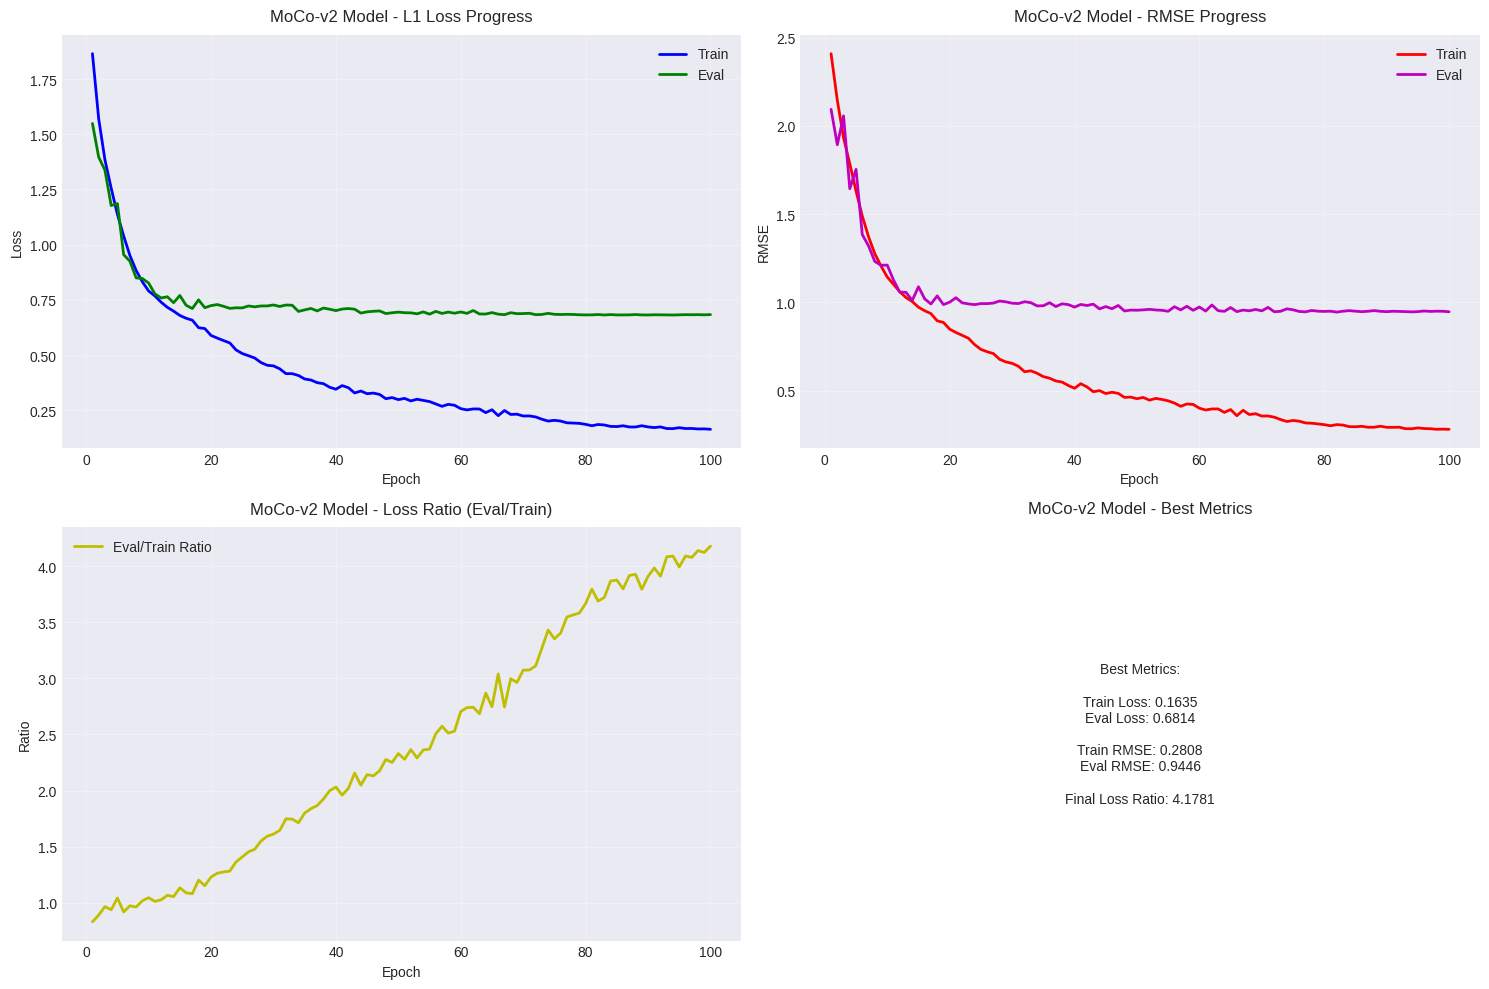

In [69]:
plot_final_metrics(metrics_diff)

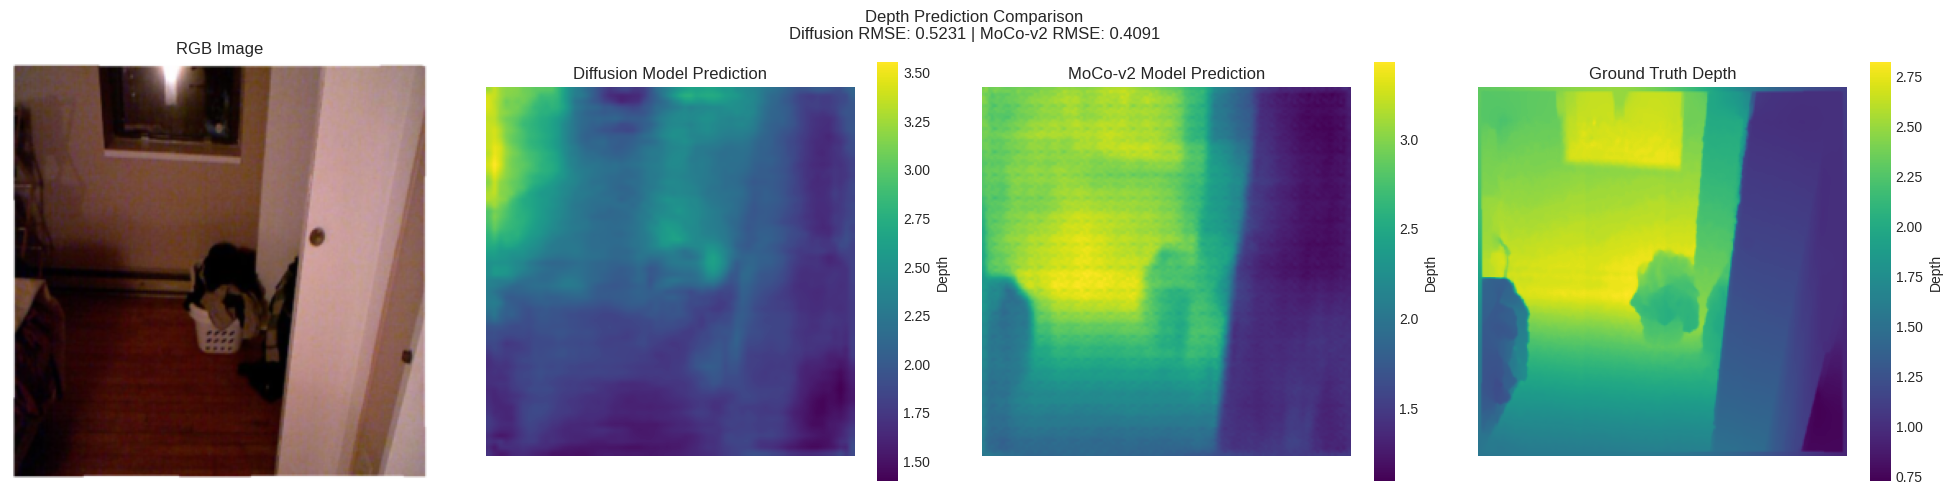

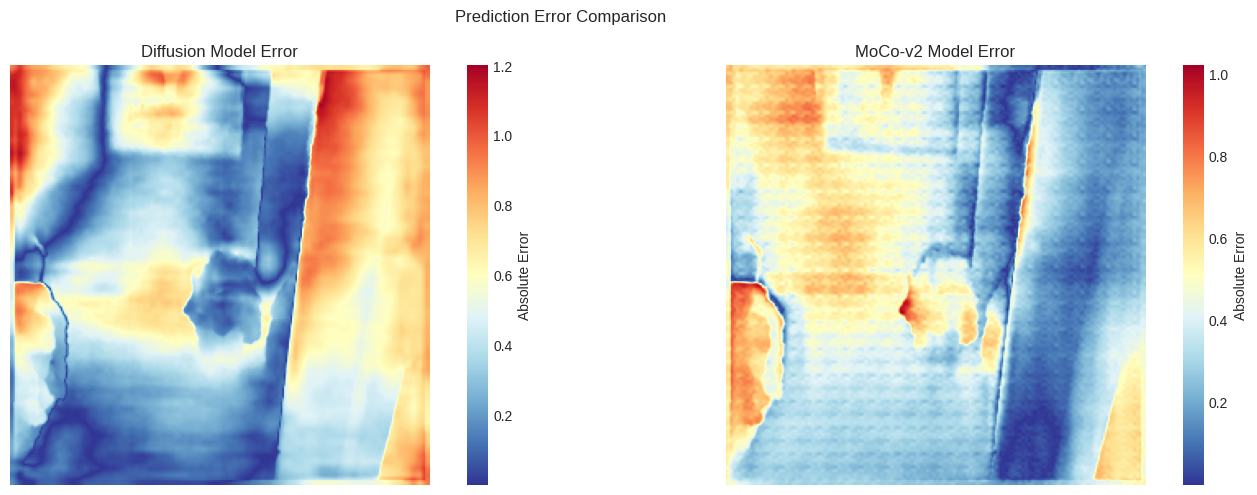

In [83]:
import random
import torch
import matplotlib.pyplot as plt

depth_model.eval()
unet_model.eval()

with torch.no_grad():

    rgb, depth = next(iter(eval_loader))
    idx = random.randint(0, len(rgb) - 1)
    rgb = rgb[idx]
    depth = depth[idx]

    rgb = rgb.unsqueeze(0).to(device)
    depth = depth.unsqueeze(0).to(device)

    pred_depth_diffusion = depth_model(rgb)
    pred_depth_moco = unet_model(rgb)

    rgb = rgb.squeeze(0).cpu()
    depth = depth.squeeze(0).squeeze(0).cpu().numpy()
    pred_depth_diffusion = pred_depth_diffusion.squeeze(0).squeeze(0).cpu().numpy()
    pred_depth_moco = pred_depth_moco.squeeze(0).squeeze(0).cpu().numpy()

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    rgb = unnormalize(rgb, mean, std).clamp(0, 1).permute(1, 2, 0).numpy()

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.title("RGB Image")
    plt.imshow(rgb)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("Diffusion Model Prediction")
    diff_plot = plt.imshow(pred_depth_diffusion, cmap='viridis')
    plt.colorbar(diff_plot, label="Depth")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title("MoCo-v2 Model Prediction")
    moco_plot = plt.imshow(pred_depth_moco, cmap='viridis')
    plt.colorbar(moco_plot, label="Depth")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("Ground Truth Depth")
    gt_plot = plt.imshow(depth, cmap='viridis')
    plt.colorbar(gt_plot, label="Depth")
    plt.axis("off")

    rmse_diffusion = np.sqrt(np.mean((pred_depth_diffusion - depth) ** 2))
    rmse_moco = np.sqrt(np.mean((pred_depth_moco - depth) ** 2))

    plt.suptitle(f'Depth Prediction Comparison\nDiffusion RMSE: {rmse_diffusion:.4f} | MoCo-v2 RMSE: {rmse_moco:.4f}')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title("Diffusion Model Error")
    diff_error = plt.imshow(np.abs(pred_depth_diffusion - depth), cmap='RdYlBu_r')
    plt.colorbar(diff_error, label="Absolute Error")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("MoCo-v2 Model Error")
    moco_error = plt.imshow(np.abs(pred_depth_moco - depth), cmap='RdYlBu_r')
    plt.colorbar(moco_error, label="Absolute Error")
    plt.axis("off")

    plt.suptitle('Prediction Error Comparison')
    plt.tight_layout()
    plt.show()

In [82]:
def count_parameters(model, model_name):
    total_params = sum(p.numel() for p in model.parameters())

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    total_params_m = total_params / 1e6
    trainable_params_m = trainable_params / 1e6

    print(f"\n{model_name} Architecture:")
    print(f"Total Parameters: {total_params_m:.2f}M")
    print(f"Trainable Parameters: {trainable_params_m:.2f}M")

    return total_params_m, trainable_params_m

moco_params = count_parameters(unet_model, "MoCo-v2 UNet")
diff_params = count_parameters(depth_model, "Diffusion UNet")

print("\nModel Size Comparison:")
print(f"MoCo-v2 vs Diffusion ratio: {moco_params[0]/diff_params[0]:.2f}x")


MoCo-v2 UNet Architecture:
Total Parameters: 71.87M
Trainable Parameters: 71.87M

Diffusion UNet Architecture:
Total Parameters: 123.68M
Trainable Parameters: 123.68M

Model Size Comparison:
MoCo-v2 vs Diffusion ratio: 0.58x
